In [61]:
import numpy as np
from scipy.signal import convolve2d
import cv2 as cv
import matplotlib.pyplot as plt

def read_img(path):
    return cv.imread(path, cv.IMREAD_GRAYSCALE)

def show_img(img, ax=plt, figsize=(30,10), **kwargs):
    ax.figure(figsize = figsize)
    ax.imshow(img, **kwargs)
    plt.axis('off')
    
    
def show_imgs(imgs, figsize=(10,10), cmap='viridis', vmin=0, vmax=255, titles=None):
    figsize = (figsize[0]*len(imgs), figsize[1])
    _, axarr = plt.subplots(1, len(imgs), figsize=figsize, tight_layout=True)
    for i in range(len(imgs)):
        ax = axarr[i]
        ax.imshow(imgs[i], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])
        
    plt.show()


# Ejercicio 1

In [115]:
def convol_1d(xs, ys, starting_point):
    ys_reversed = np.flip(ys)
    left_padding = starting_point
    right_padding = len(ys) - starting_point - 1
    padded_xs = np.pad(xs, (left_padding,right_padding), 'constant', constant_values=(0,0))
    ending_point = len(padded_xs) - right_padding - 1
    res = np.zeros(len(padded_xs))
    for pos in range(starting_point, ending_point):
        accum = 0
        for y_index in range(len(ys_reversed)):
            accum += (ys_reversed[y_index] * padded_xs[pos + y_index - starting_point])
        res[pos] = accum
    return res.astype(np.int64)

In [111]:
xs1 = np.array([0, 1, 0, 0, 0, 0])
h1 = np.array([0, 2, 1, 0, 0])

print(convol_1d(xs1, h1, 1))

[0 1 0 0 0 0 0 0 0 0]


In [112]:
xs2 = np.array([0, 0, 1, 0, 0, 0])
h2 = h1

print(convol_1d(xs2, h2, 1))

[0 2 1 0 0 0 0 0 0 0]


In [113]:
xs3 = np.array([0, 2, -1, 0, 0, 0])
h3 = np.array([0, -1, 2, 1, 0])

print(convol_1d(xs3, h3, 1))

[ 0  5  0 -1  0  0  0  0  0  0]


In [114]:
# xs3 = np.array([0, 2, -1, 0, 0, 0])
# h3 = np.array([0, -1, 2, 1, 0])

# print(convol_1d(xs3, h3))
# print(np.convolve(xs3, h3, mode='full'))

# Ejercicio 2

In [7]:
I = np.array([[1,4,1],
              [2,5,3]])

convi = np.array([
    [0,-1,1],
    [-1,4,-1],
    [0,-1,0]
])

convii = np.array([
    [1,2,3]
])

conviii = np.array([
    [-2],
    [3],
    [-1]
])

print(convolve2d(I, convi))
print(convolve2d(I, convii))
print(convolve2d(I, conviii))

[[ 0 -1 -3  3  1]
 [-1 -2 11  2  2]
 [-2  2 11  6 -3]
 [ 0 -2 -5 -3  0]]
[[ 1  6 12 14  3]
 [ 2  9 19 21  9]]
[[-2 -8 -2]
 [-1  2 -3]
 [ 5 11  8]
 [-2 -5 -3]]


b) 
Dado el algoritmo que se nos da para hacer la convolucion I * H matrices de (M1,N1) y (M2,N2) respectivamente, se puede ver que a la matriz resultante es del mismo tamaño que I con un extra de padding necesario para centrar H en cada punto de I.
Por ejemplo, para centrar H en la posicion (0,0) de I, es necesario agregarle M2/2 -0.5 filas y N2/2-0.5 columnas (Con M2 y N2 impares). de esta forma se le agrega en 2*(M2/2-0.5) = M2-1  filas y N2-1 columnas, con lo cual la matriz resultante termina siendo de dimensión (M1+M2-1, N1+N2-1)

In [8]:
def sum_matrix(I,H,row,col,sp):
    s = 0
    for k_row in range(H.shape[0]):
        for k_col in range(H.shape[1]):
            s += I[sp[0]+1+row-k_row, sp[1]+1+col-k_col] * H[k_row,k_col]
            
    return s
            
def my_convolve2d(I, H, fun=sum_matrix):
    sp = (int(H.shape[0]/2 - 0.5), int(H.shape[1]/2 - 0.5))
    I_padded = np.pad(I, ((sp[0],sp[0]), (sp[1],sp[1])), 'constant', constant_values=(0,0))

    result_matrix = np.zeros(I.shape)
    for row in range(result_matrix.shape[0]):
        for col in range(result_matrix.shape[1]):
            result_matrix[row, col] = fun(I_padded, H, row, col, sp)
                    
    return result_matrix

In [9]:
H = np.array([
    [1,2,3],
    [1,2,3],
    [1,2,3]
])

I = np.array([
    [3,4,5],
    [2,5,6],
    [3,1,4]
])

# Conmutatividad H ∗ I = I ∗ H

assert np.all(my_convolve2d(H,I) == my_convolve2d(I,H))

# Linealidad (s · I) ∗ H = I ∗ (s · H) = s · (I ∗ H)
# (I1 + I2) ∗ H = (I1 ∗ H) + (I2 ∗ H)
# (b + I) ∗ H 6= b + (I ∗ H)

s = 4
assert np.all(my_convolve2d(s * I,H) == s* my_convolve2d(I,H))

# Asociatividad (A ∗ B) ∗ C = A ∗ (B ∗ C)
A = np.array([
    [4,5,6],
    [1,2,3],
    [5,7,8]
])
B = I
C = H

print(my_convolve2d(my_convolve2d(A,B),C))
print(my_convolve2d(A,my_convolve2d(B,C)))

print(convolve2d(convolve2d(A,B,mode='same'),C,mode='same'))
print(convolve2d(A,convolve2d(B,C,mode='same'),mode='same'))

print(np.all(convolve2d(convolve2d(A,B),C)==convolve2d(A,convolve2d(B,C))))



[[ 439.  971. 1067.]
 [ 627. 1394. 1541.]
 [ 464. 1026. 1128.]]
[[ 448.  885.  884.]
 [ 692. 1394. 1404.]
 [ 546. 1081. 1079.]]
[[ 439  971 1067]
 [ 627 1394 1541]
 [ 464 1026 1128]]
[[ 448  885  884]
 [ 692 1394 1404]
 [ 546 1081 1079]]
True


## Ejercicio 4

In [10]:
media1 = np.ones((3,3)) / 9
media2 = np.ones((21,21)) / (21*21)
media3 = np.array([
    [1,1],
    [1,1],
    [1,1]
]) / 6

gauss_mask = np.array([
    [3,5,3],
    [5,9,5],
    [3,5,3],
])


def min_matrix(I, H, row, col, sp):
    m = np.max(I)
    for k_row in range(H.shape[0]):
        for k_col in range(H.shape[1]):
            val = I[sp[0]+1+row-k_row, sp[1]+1+col-k_col]
            if (val < m):
                m = val
                
    return m

def max_matrix(I, H, row, col, sp):
    m = np.min(I)
    for k_row in range(H.shape[0]):
        for k_col in range(H.shape[1]):
            val = I[sp[0]+1+row-k_row, sp[1]+1+col-k_col]
            if (val > m):
                m = val
                
    return m


def mediana_matrix(I, H, row, col, sp):
    values = []
    for k_row in range(H.shape[0]):
        for k_col in range(H.shape[1]):
            values.append(I[sp[0]+1+row-k_row, sp[1]+1+col-k_col])
                
    return np.median(values)


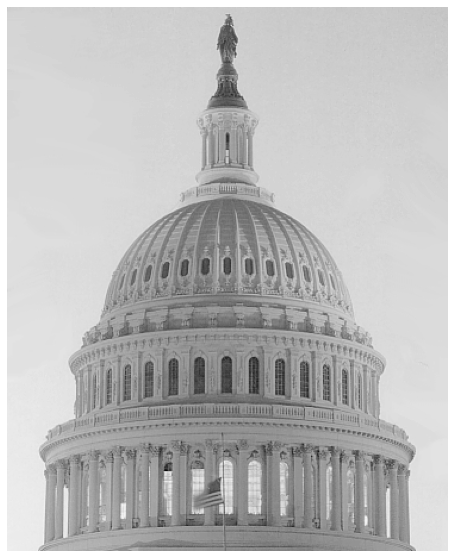

In [20]:
im = read_img('./imagenes/cupula.jpg')
show_img(im,cmap='gray')

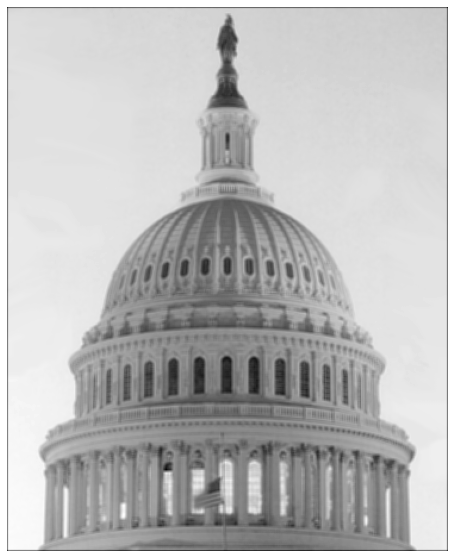

In [15]:
show_img(my_convolve2d(im, media1), cmap='gray')

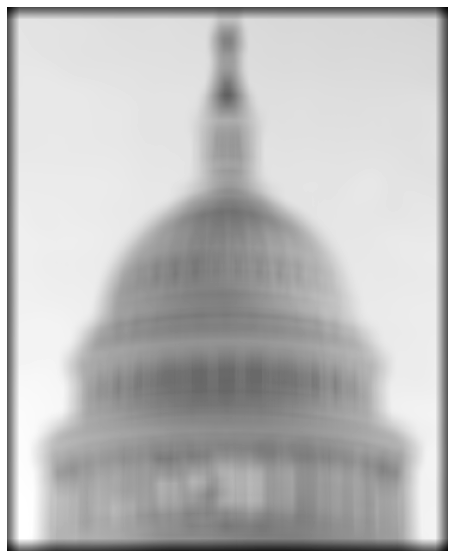

In [23]:
show_img(convolve2d(im, media2, mode='same'), cmap='gray')

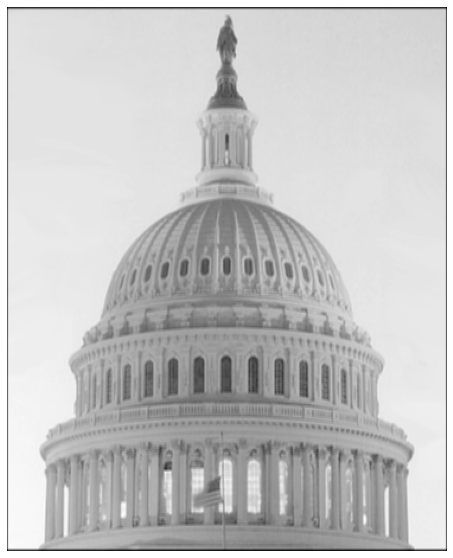

In [29]:
show_img(convolve2d(im, media3), cmap='gray')

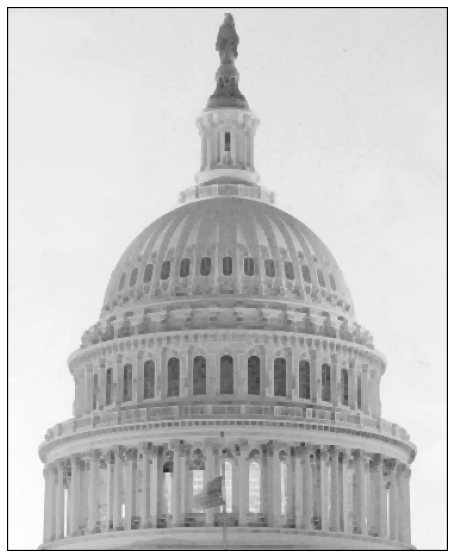

In [40]:
show_img(my_convolve2d(im, media1, fun=min_matrix), cmap='gray')

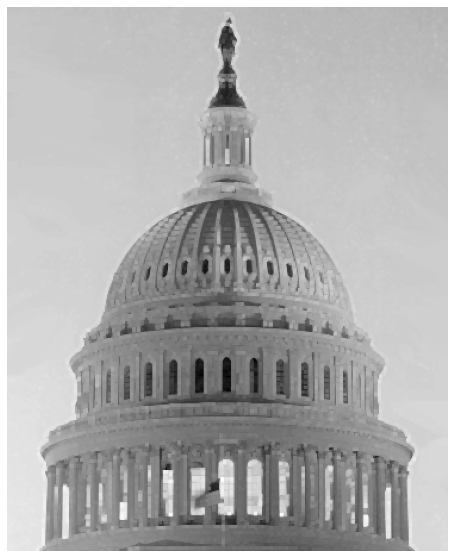

In [41]:
show_img(my_convolve2d(im, media1, fun=max_matrix), cmap='gray')

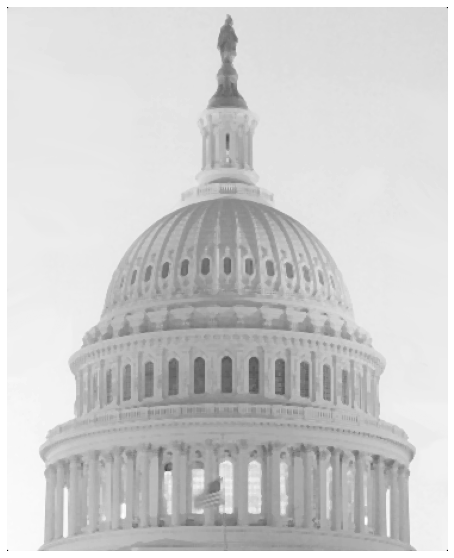

In [50]:
show_img(my_convolve2d(im, media1, fun=mediana_matrix), cmap='gray')

## Ejercicio 5 UnsharpMasking

In [81]:
from scipy import signal

def suavizar(img, sigma):
    w = signal.gaussian(51, sigma)
    suav = signal.sepfir2d(img, w, w)
    # Normalizo la imagen suavizada
    suav /= suav.max()/255.0
    return suav

def unsharp(img, sigma=7, a=1):
    return (1 + a)*img - a*suavizar(np.copy(img), sigma)

In [82]:
im = im.astype(np.float64)
a = 3
sigma = 4

In [83]:
suavizada = suavizar(im, sigma)

In [89]:
i_moño = im - suavizada
i_moño /= i_moño.max()/255.0

In [90]:
unsharped = unsharp(im, sigma=sigma, a=a) 

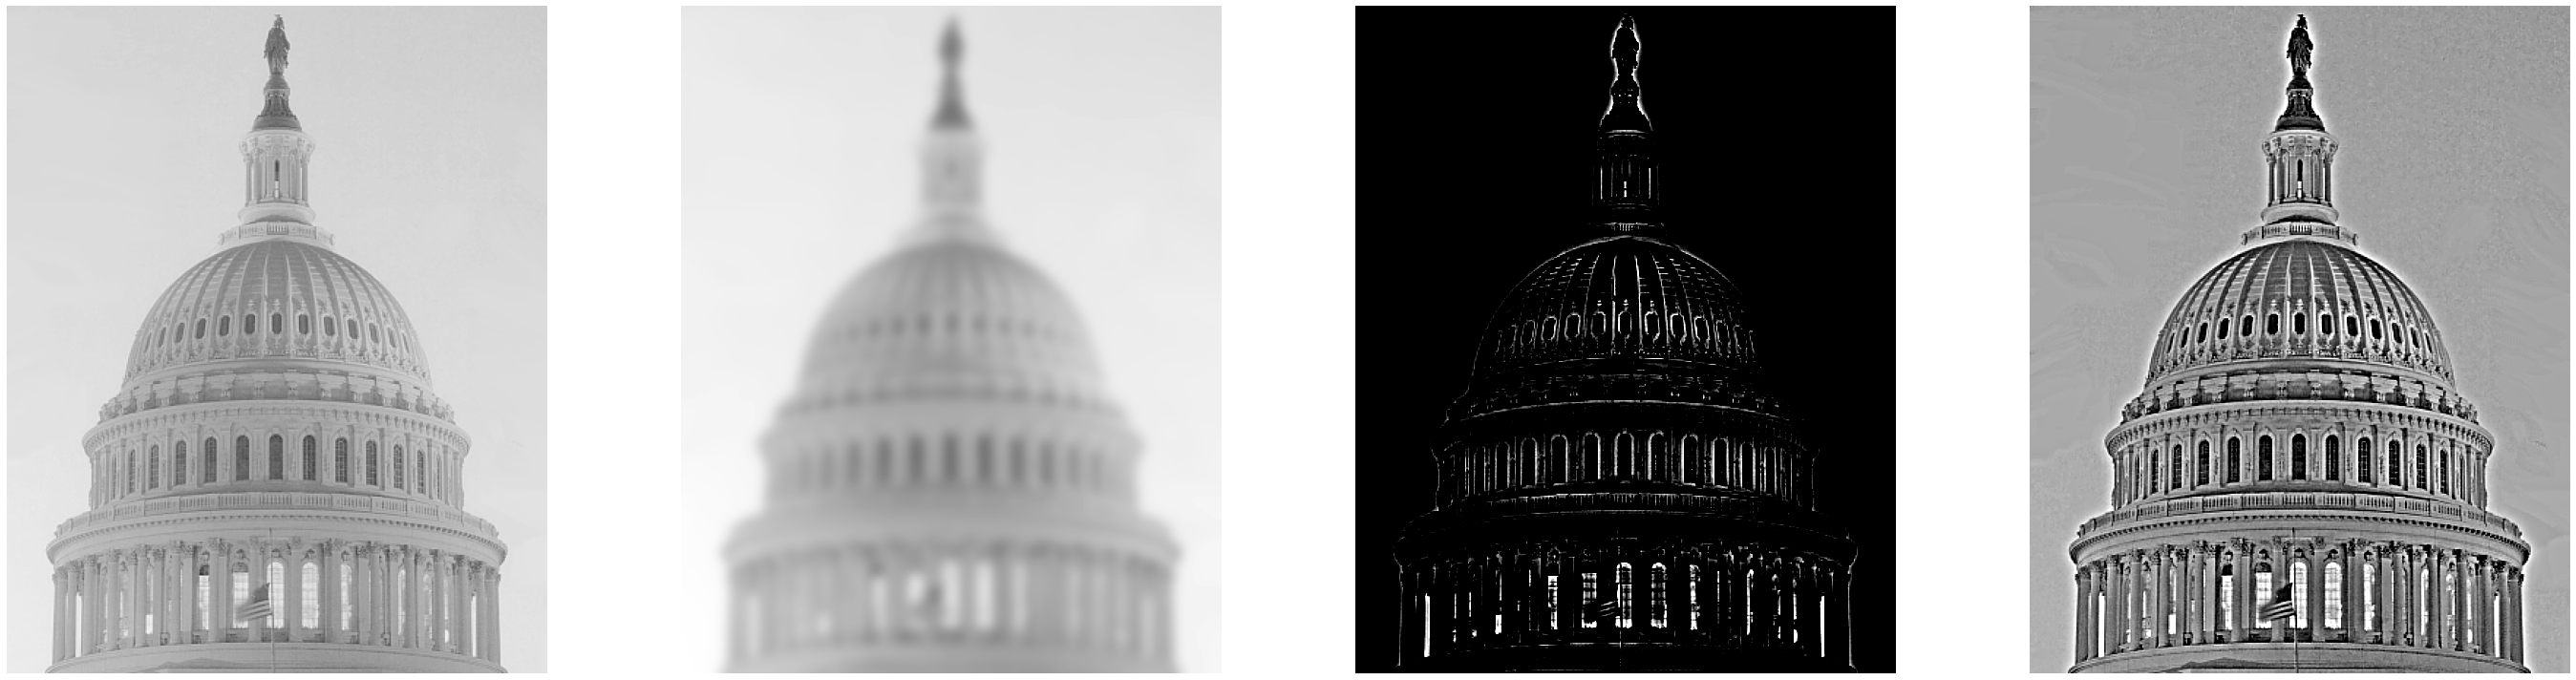

In [92]:
show_imgs([im, suavizada, a*i_moño, unsharped], cmap='gray')

In [93]:
a_s = [1, 3, 10]
sigmas = [1,3,6,10]

sharpenes = []
for a in a_s:
    for sigma in sigmas:
        sharpenes.append(unsharp(im, sigma=sigma, a=a))

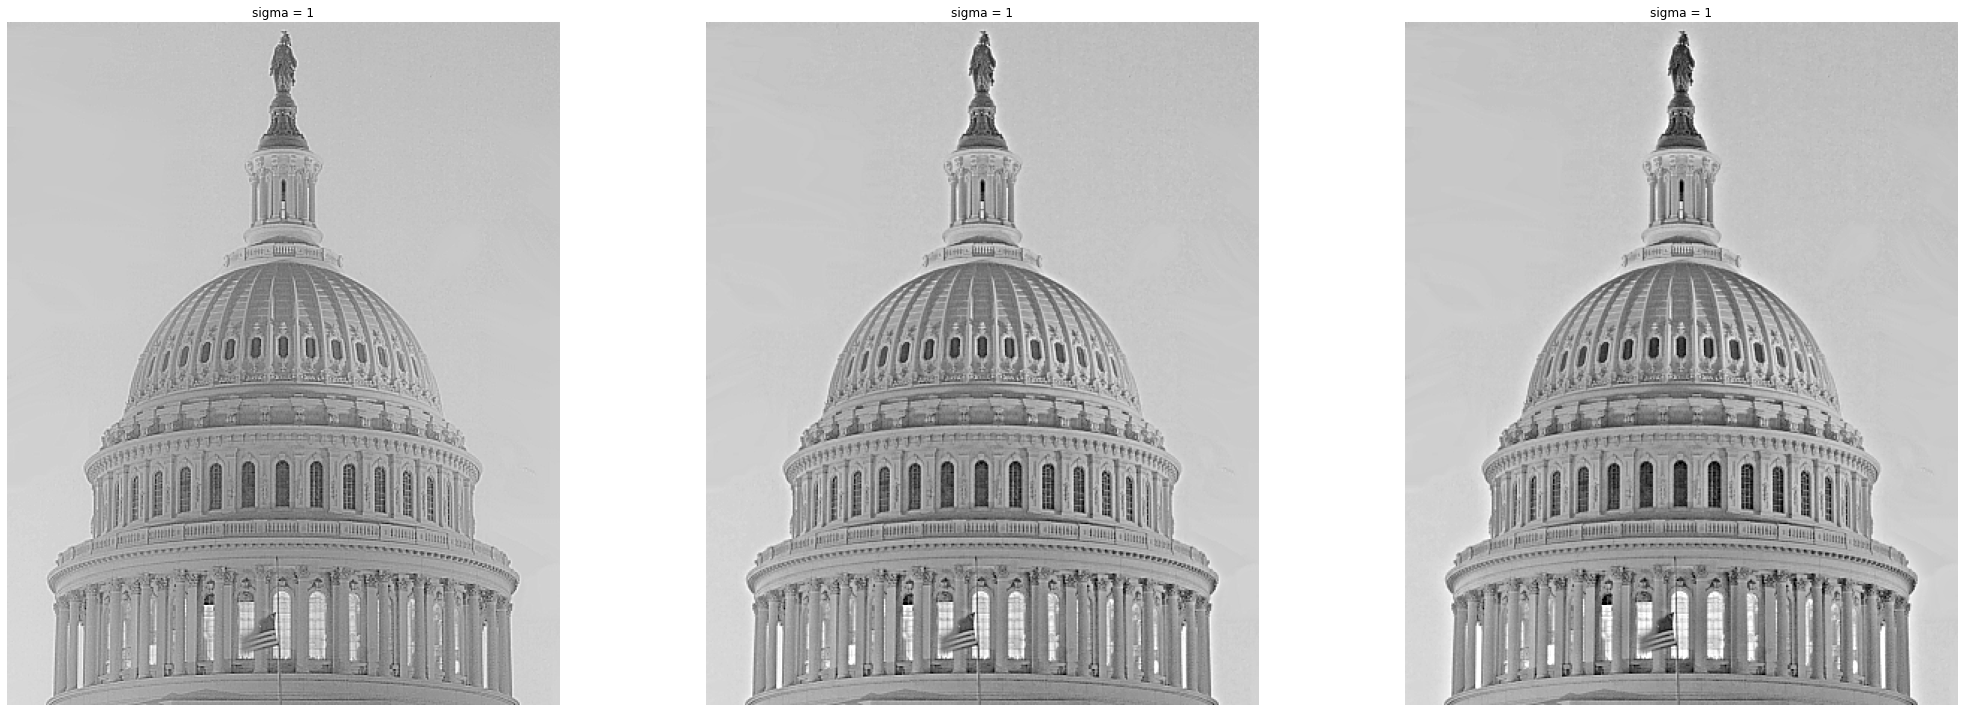

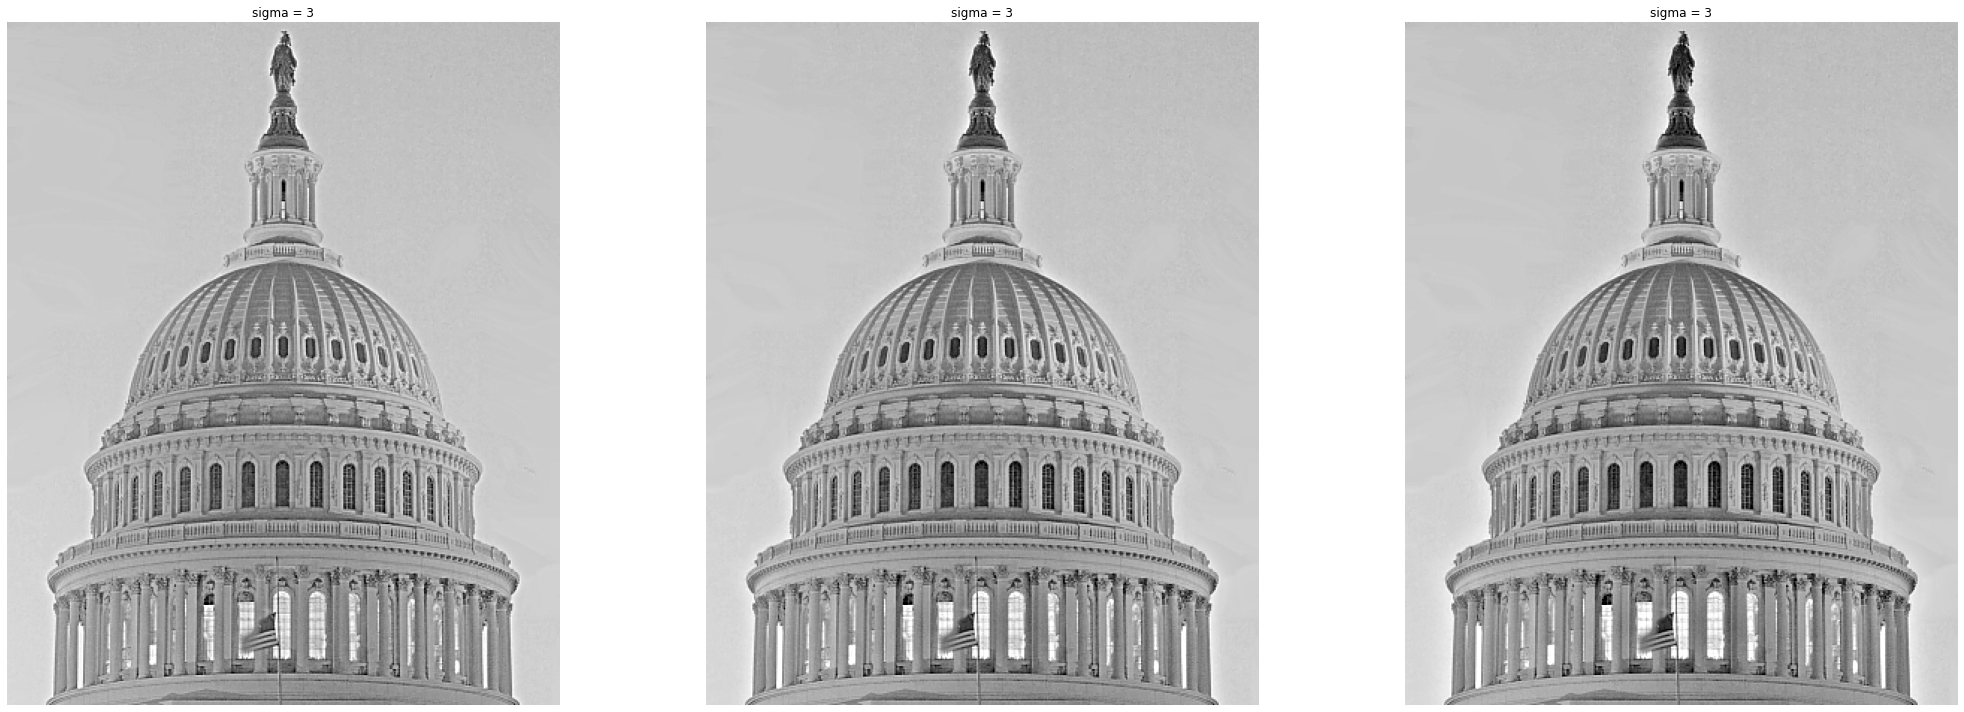

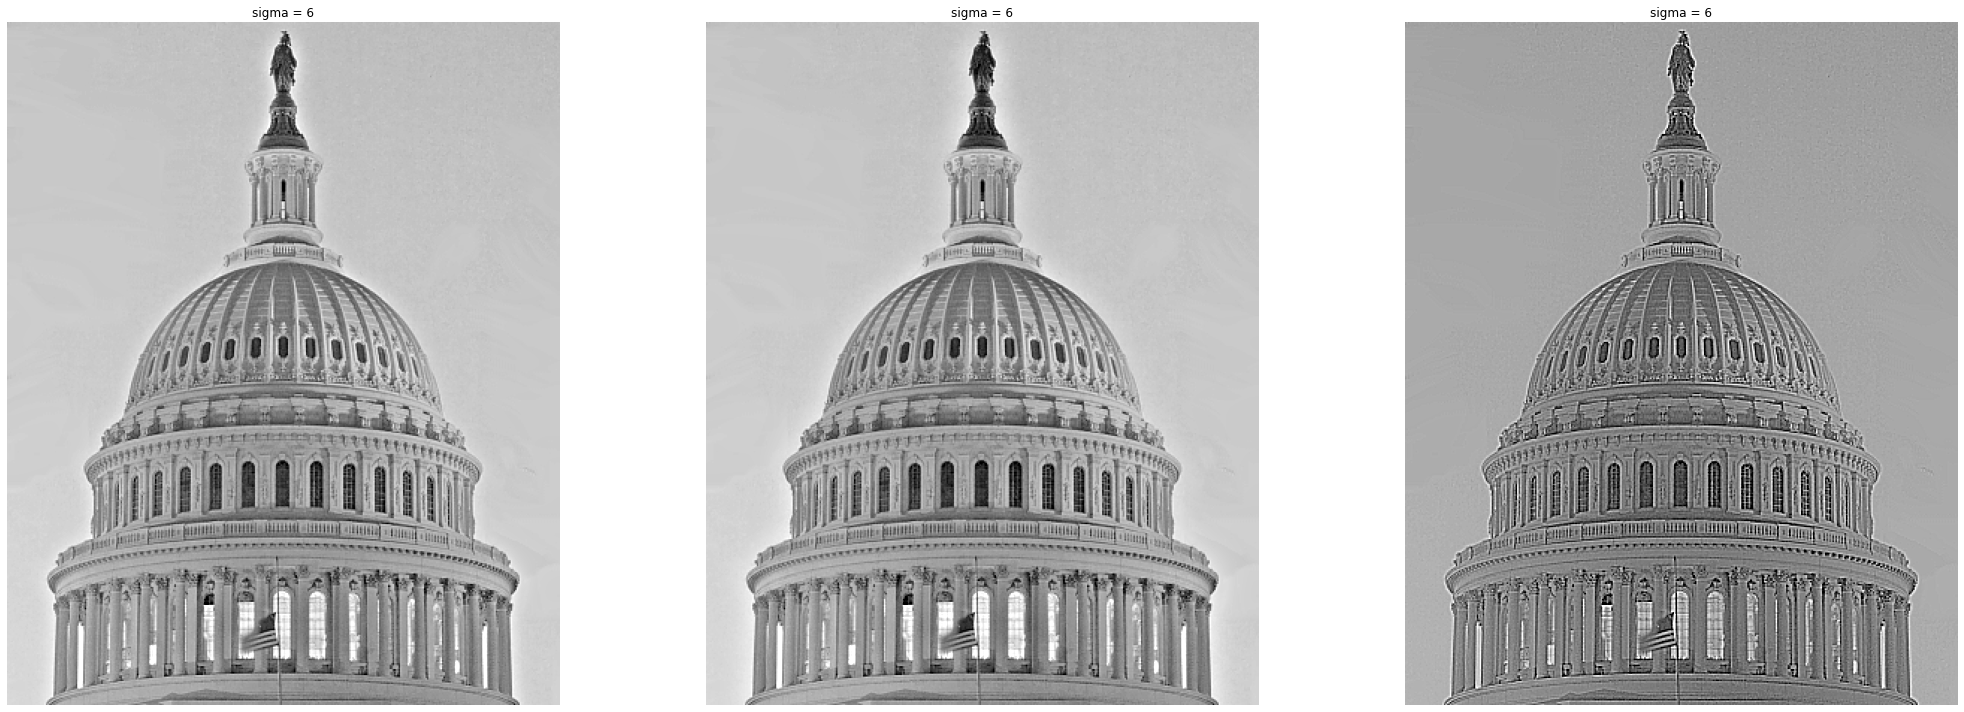

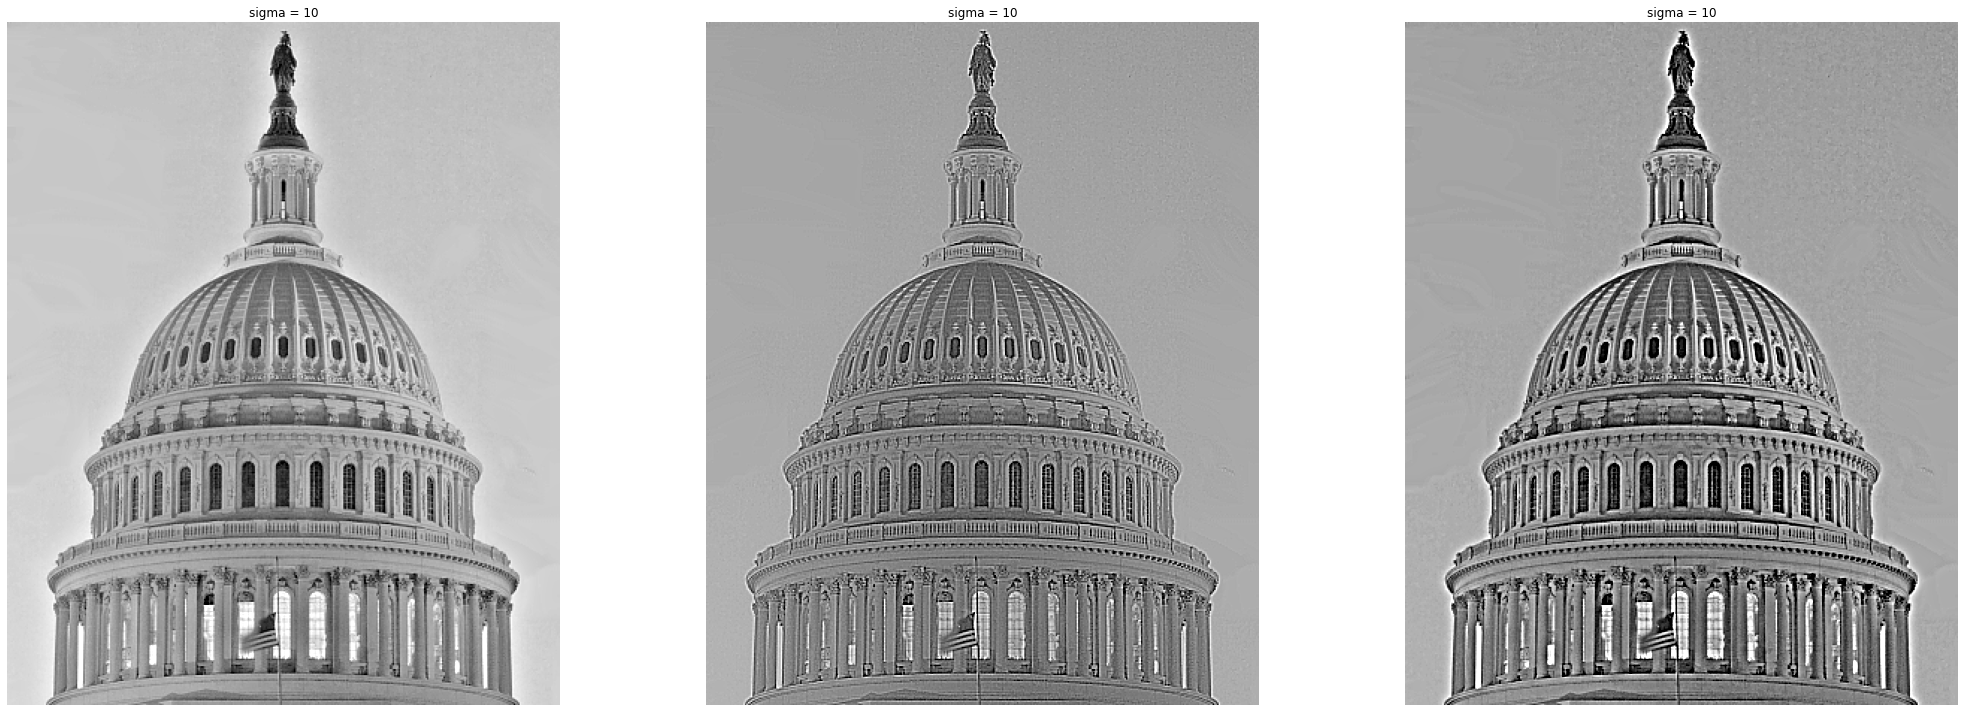

In [100]:
for i in range(len(sharpenes) // len(a_s)):
    show_imgs(sharpenes[i:i+len(a_s)], cmap='gray',titles=[f'sigma = %s' % sigmas[i]] * len(a_s))